In [57]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gc
import os
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pylab as plt

from utils_shear_ana import pltutil
from utils_shear_ana import chainutil
from chainconsumer import ChainConsumer
from matplotlib.ticker import AutoMinorLocator

import getdist
from getdist import MCSamples
from getdist import plots as GDplots
import numpy.lib.recfunctions as rfn
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
blind_by = None

In [3]:
dir0 = os.getcwd()
pid = 2
pdir = 'root%d' %pid
os.chdir(pdir)

LOADING CHAIN FROM FILE:  ./0_fid/cat0/outputs/polychord_fid_cat0.txt
LOADING CHAIN FROM FILE:  ./0_fid/cat0/outputs/polychord_fid_cat0.txt


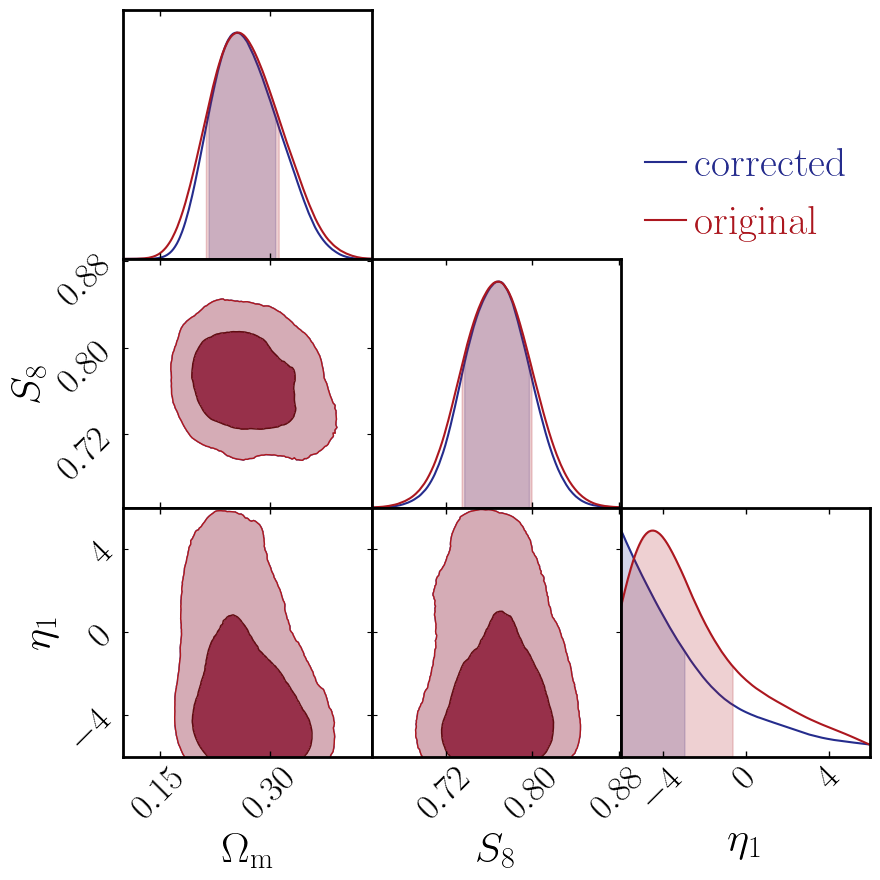

In [97]:
plt.close()
outlist=[]
cnamelist = []
infname0='./0_fid/cat0/outputs/polychord_fid_cat0.txt'
outlist.append(chainutil.read_cosmosis_chain(infname0, as_correction=True))
outlist.append(chainutil.read_cosmosis_chain(infname0, as_correction=True))
cnamelist = [ 'corrected', 'original']
plt.close()
nlist = ['omega_m', 's_8', '' 'alpha1']
fig=pltutil.plot_chain_corner(
    outlist,
    cnamelist,
    blind_by,
    nlist,
    scale = 2.7,
    plot_hists=True,
    shade=True,
    correct_boundary=[True, False],
    correct_multbias=[True, False],
)
fig.savefig("../paper_plots/cat0/chainconsumer_problem_rev.pdf")

LOADING CHAIN FROM FILE:  ./0_fid/cat0/outputs/polychord_fid_cat0.txt
LOADING CHAIN FROM FILE:  ./0_fid/cat0/outputs/polychord_fid_cat0.txt


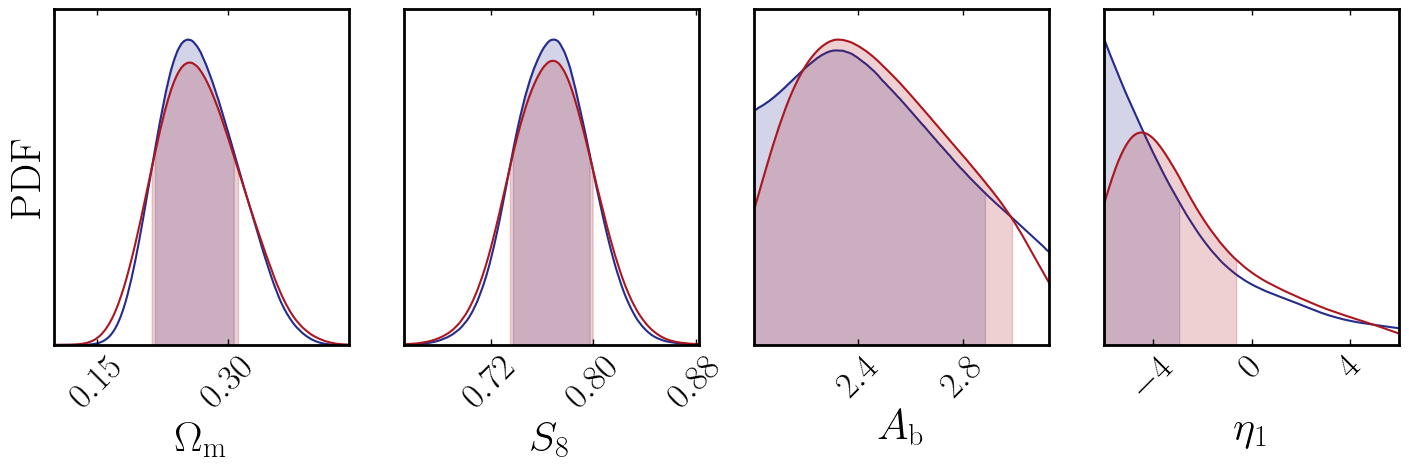

In [110]:
plt.close()
outlist=[]
cnamelist = []
infname0='./0_fid/cat0/outputs/polychord_fid_cat0.txt'
outlist.append(chainutil.read_cosmosis_chain(infname0, as_correction=True))
outlist.append(chainutil.read_cosmosis_chain(infname0, as_correction=True))
cnamelist = [ 'corrected', 'original']
plt.close()
nlist = ['omega_m', 's_8', 'a_bary', 'alpha1']
fig=pltutil.plot_chain_corner(
    outlist,
    cnamelist,
    blind_by,
    nlist,
    scale = 2.7,
    plot_hists=True,
    shade=True,
    correct_boundary=[True, False],
    correct_multbias=[True, False],
)
fig.tight_layout()
fig.savefig("../paper_plots/cat0/chainconsumer_problem_rev.pdf")

LOADING CHAIN FROM FILE:  ./0_fid/cat0/outputs/polychord_fid_cat0.txt


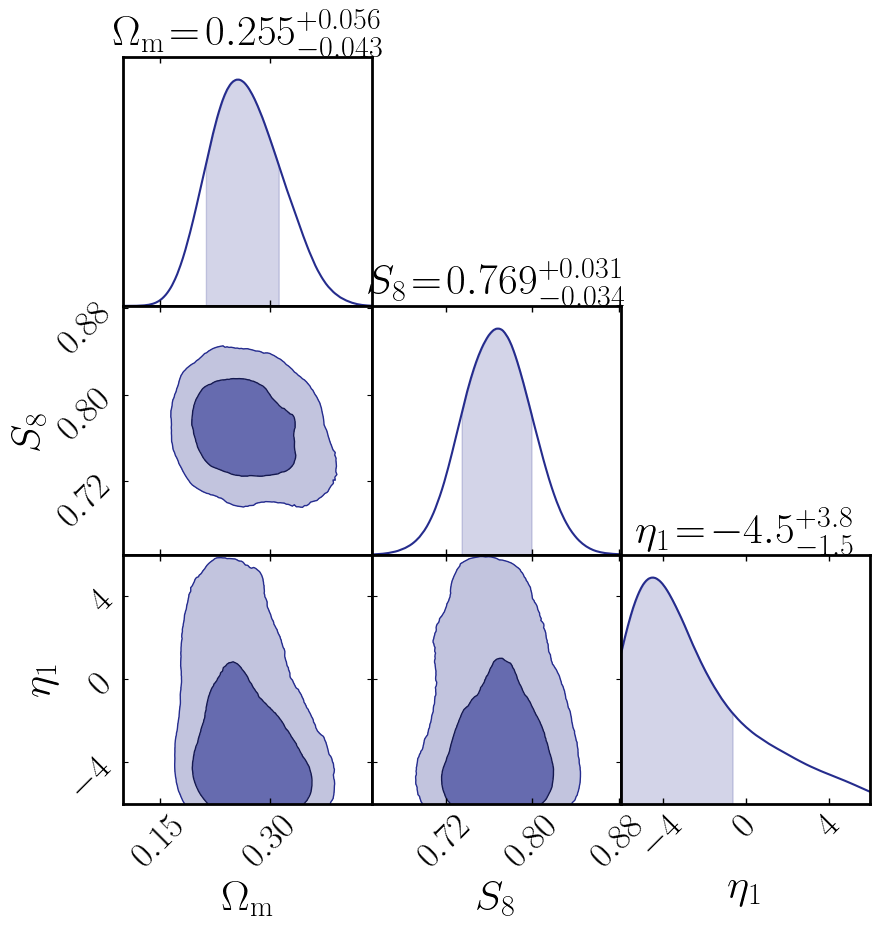

In [80]:
plt.close()
outlist=[]
cnamelist = []
infname0='./0_fid/cat0/outputs/polychord_fid_cat0.txt'
outlist.append(chainutil.read_cosmosis_chain(infname0, as_correction=True))
cnamelist = [ 'fiducial$^{*}$']
plt.close()
nlist = ['omega_m', 's_8', 'alpha1']
fig=pltutil.plot_chain_corner(
    outlist,
    cnamelist,
    blind_by,
    nlist,
    scale = 2.7,
    plot_hists=True,
    shade=True,
    color_use=[colors[0]],
    correct_boundary=False,
    correct_multbias=False,
)

In [89]:
from getdist.chains import loadNumpyTxt
from getdist.mcsamples import MCSamples
from getdist.types import BestFit
from getdist.paramnames import ParamInfo

def MCSamplesFromCosmosis(chain_root, chain_min_root=None,
                          param_name_dict=None, param_label_dict=None,
                          name_tag=None, settings=None,
                          flip_dz=True, as_correction=True, return_info=False, return_ranges=False):
    """
    Function to import Cosmosis chains in GetDist.

    :param chain_root: the name and path to the chain or the path to the
        folder that contains it.
    :param chain_min_root: (optional) name of the file containing the
        explicit best fit.
    :param param_name_dict: (optional) a dictionary with the mapping between
        cosmosis names and reasonable parameter names.
    :param param_label_dict: (optional) dictionary with the mapping between
        parameter names and parameter labels, since Cosmosis does not save
        the labels in the chain.
    :param name_tag: (optional) a string with the name tag for the chain.
    :param settings: (optional) dictionary of analysis settings to override
        getdist defaults
    :return: The :class:`~getdist.mcsamples.MCSamples` instance
    """
    # decide if the user passed a folder or a chain:
    if os.path.isfile(chain_root+'.txt'):
        chain_file = chain_root+'.txt'
    elif os.path.isdir(chain_root):
        # look for the chain file:
        temp = list(filter(lambda x: 'chain.txt' in x, os.listdir(chain_root)))
        if len(temp) == 0:
            raise ValueError('No chain file found in folder', chain_root)
        chain_file = chain_root+'/'+temp[0]
    else:
        raise ValueError('Input chain root is not a folder nor a file.')
    # get all the commented lines in the chain file:
    info = get_cosmosis_info(chain_file)
    # get the parameter names:
    param_names = get_param_names(info)
    # get the parameter labels from the user provided dictionary:
    param_labels = get_param_labels(info, param_names, param_label_dict)
    # get the sampler:
    sampler = get_sampler_type(info)
    # get the name tag:
    if name_tag is None:
        name_tag = get_name_tag(info)
    # get the samples weights and likelihood:
    chain = loadNumpyTxt(chain_file, skiprows=0)
    # parse the chain depending on the sampler that produced it:
    if sampler == 'nested':
        # get number of samples to use:
        nsamples = int(list(filter(lambda x: 'nsample=' in x, info))
                       [0].replace(' ', '').split('=')[1])
        # get the chain:
        chain = chain[-nsamples:]
        
        # a_s has unit of [1e-9]
        if "a_s" in param_names:
            chain[:, param_names.index("a_s")] = chain[:, param_names.index("a_s")] * 1e9
        if "ombh2" in param_names:
            chain[:, param_names.index("ombh2")] = chain[:, param_names.index("ombh2")] * 1e3
        
        # flip the delta_z
        if flip_dz:
            for i in range(1, 20):
                inm = "bias_%d" % i
                if inm in param_names:
                    chain[:, param_names.index(inm)] = -1 * chain[:, param_names.index(inm)]
                else:
                    break


        # get all quantities:
        indexes = [i for i in range(len(param_names))
                   if i != param_names.index('weight')
                   and i != param_names.index('post')]
        samples = chain[:, indexes]
        weights = chain[:, param_names.index('weight')]
        loglike = chain[:, param_names.index('post')]
        
        if as_correction:
            if "lnAs" in chain_root:
                weights = weights * chain[:, param_names.index('sigma_8')]
            else:
                weights = weights * chain[:, param_names.index('sigma_8')] / chain[:, param_names.index('a_s')]

        # pre processing
        samples = samples[weights > 0]
        loglike = loglike[weights > 0]
        weights = weights[weights > 0]
        
        
        # delete the weights and likelihood from names:
        if param_labels is not None:
            param_labels.pop(param_names.index('weight'))
            param_labels.pop(param_names.index('post'))
        param_names.pop(param_names.index('weight'))
        param_names.pop(param_names.index('post'))
    elif sampler == 'mcmc':
        # get all quantities:
        indexes = [i for i in range(len(param_names))
                   if i != param_names.index('post')]
        samples = chain[:, indexes]
        loglike = chain[:, param_names.index('post')]
        # Cosmosis does not weight samples:
        samples, idx, weights = np.unique(samples, return_index=True, return_counts=True, axis=0)
        loglike = loglike[idx]
        # delete the weights and likelihood from names:
        if param_labels is not None:
            param_labels.pop(param_names.index('post'))
        param_names.pop(param_names.index('post'))
    elif sampler == 'uncorrelated':
        # get all quantities:
        indexes = [i for i in range(len(param_names))
                   if i != param_names.index('post')]
        samples = chain[:, indexes]
        loglike = chain[:, param_names.index('post')]
        weights = None
        # delete the weights and likelihood from names:
        if param_labels is not None:
            param_labels.pop(param_names.index('post'))
        param_names.pop(param_names.index('post'))
    else:
        raise ValueError('Unknown sampler')
    # get the ranges:
    ranges = get_ranges(info)
    # a_s has unit of [1e-9]
    if "a_s" in param_names:
        ranges["a_s"] = np.array(ranges["a_s"]) * 1e9 
    if "ombh2" in param_names:
        ranges["ombh2"] = np.array(ranges["ombh2"]) * 1e3 
    
    # transform param names:
    if param_name_dict is not None:
        for i, name in enumerate(param_names):
            if name in param_name_dict.keys():
                param_names[i] = param_name_dict[name]
                if name in ranges.keys():
                    ranges[param_name_dict[name]] = ranges.pop(name)
        #for i, name in enumerate(param_names):
        #    if name in param_name_dict.keys():
    # initialize the samples:
    mc_samples = MCSamples(samples=samples, weights=weights,
                           loglikes=-2.*loglike,
                           sampler=sampler, names=param_names,
                           labels=param_labels, ranges=ranges,
                           ignore_rows=0, name_tag=name_tag,
                           settings=settings)
    # set running parameters:
    for name in mc_samples.getParamNames().parsWithNames(
            mc_samples.getParamNames().list()):
        if name.name in ranges.keys():
            name.isDerived = False
        else:
            name.isDerived = True
    # polish the samples removing nans:
    mc_samples = polish_samples(mc_samples)
    # get the best fit:
    if chain_min_root is not None:
        # since getdist does not cache the best fit we have to override the
        # method in this brute way:
        funcType = types.MethodType
        mc_samples.getBestFit = funcType(functools.partial(get_maximum_likelihood,
                                                           chain_min_root=chain_min_root,
                                                           param_name_dict=param_name_dict,
                                                           param_label_dict=param_label_dict),
                                                           mc_samples)
    # update statistics:
    mc_samples.updateBaseStatistics()
    #
    if return_info:
        return mc_samples, info
    elif return_ranges:
        return mc_samples, ranges    
    else:
        return mc_samples

def get_cosmosis_info(file):
    """
    Parse a file to get all the information about a Cosmosis run.

    :param file: path and name of the file to parse.
    :return: a list of strings with the cosmosis parameters for the run.
    """
    with open(file, 'r') as _file:
        info = []
        for ln in _file:
            if ln.startswith('#'):
                info.append(ln[1:])
    # polish the info strings:
    info = list(filter(None, [line.replace('#', '').strip() for line in info]))
    #
    return info



def get_param_names(info):
    """
    Get the parameter names for a Cosmosis run.

    :param info: a list of strings with the cosmosis parameters for the run.
    :return: a list of strings with the parameter names.
    """
    #return info[0].split('\t')
    colnames = info[0].split('\t')
    colnames = [c.lower().split("--")[-1] for c in colnames]    
    return colnames

def get_param_labels(info, param_names, param_label_dict):
    """
    Get the labels for the parameter names of a Cosmosis run.

    :param info: a list of strings with the cosmosis parameters for the run.
    :param param_names: a list of strings with the parameter names.
    :param param_label_dict: a dictionary with the mapping between names and
        labels.
    :return: a list of strings with the parameter labels.
    """
    if param_label_dict is not None:
        param_labels = []
        for name in param_names:
            if name in param_label_dict.keys():
                param_labels.append(param_label_dict[name])
            else:
                param_labels.append(name)
    else:
        param_labels = None
    #
    return param_labels



def get_sampler_type(info):
    """
    Get the sampler type for a chain given the a list of strings containing the
    cosmosis run parameter informations.
    To process the sampler type the function defines internally a dictionary
    with the mapping from sampler name to sampler type.

    :param info: a list of strings with the cosmosis parameters for the run.
    :return: a string with the sampler type if any, otherwise returns none.
    """
    # define the dictionary with the mapping:
    sampler_dict = {
                    'polychord': 'nested',
                    'multinest': 'nested',
                    'apriori': 'uncorrelated',
                    'emcee': 'mcmc',
                    'pmaxlike': 'max_like',
                    'maxlike': 'max_like'
                    }
    # find the sampler in the parameters:
    temp = list(filter(lambda x: 'sampler' in x, info))
    if len(temp) > 0:
        sampler = temp[0].replace(' ', '').split('=')[1].lower()
        if sampler in sampler_dict.keys():
            sampler = sampler_dict[sampler]
        else:
            raise ValueError('Unknown input sampler')
    else:
        sampler = None
    #
    return sampler



def get_name_tag(info):
    """
    Get the name tag for a chain given the a list of strings containing the
    cosmosis run parameter informations.

    :param info: a list of strings with the cosmosis parameters for the run.
    :return: a string with the name tag if any, otherwise returns none.
    """
    temp = list(filter(lambda x: 'run_name' in x, info))
    if len(temp) > 0:
        name_tag = temp[0].replace(' ', '').split('=')[1].lower()
        name_tag = name_tag.rstrip().lstrip()
    else:
        name_tag = None
    #
    return name_tag



def get_ranges(info):
    """
    Get the ranges for the parameters from the info file.

    :param info: a list of strings with the cosmosis parameters for the run.
    :param param_names: a list with the parameter names.
    :return: a dictionary with the parameter ranges.
    """
    ranges = {}
    colnames = info[0].split('\t')
    
    for name in colnames:
        try:
            # look for the section:
            section = '['+name.split('--')[0]+']'
            pname = name.split('--')[1]
            section_index = info.index(section)
            temp = list(filter(lambda x:
                               pname in x[1] and x[0] > section_index,
                               enumerate(info)))[0][1]
            _min = float(list(filter(None, temp.split()))[2])
            _max = float(list(filter(None, temp.split()))[4])
            ranges[pname] = [_min, _max]
        except:
            pass
    #
    return ranges



def polish_samples(chain):
    """
    Remove fixed parameters and samples with some parameter that is Nan
    from the input chain.

    :param chain: :class:`~getdist.mcsamples.MCSamples` the input chain.
    :return: :class:`~getdist.mcsamples.MCSamples` the polished chain.
    """
    # delete fixed parameters:
    chain.deleteFixedParams()
    # we need to delete nan columns:
    fixed = []
    values = []
    for i in range(chain.samples.shape[1]):
        if np.all(np.isnan(chain.samples[:, i])):
            fixed.append(i)
            values.append(chain.samples[0, i])
    chain.changeSamples(np.delete(chain.samples, fixed, 1))
    if hasattr(chain, 'ranges'):
        for ix, value in zip(fixed, values):
            chain.ranges.setFixed(chain.paramNames.names[ix].name,
                                  value)
    chain.paramNames.deleteIndices(fixed)
    chain._getParamIndices()
    # now we need to delete nan samples:
    nan_filter = np.all(np.logical_not(np.isnan(chain.samples)), axis=1)
    chain.filter(where=nan_filter)
    #
    return chain



def get_maximum_likelihood(dummy, max_posterior, chain_min_root,
                           param_name_dict, param_label_dict):
    """
    Import the maximum likelihood file for a Cosmosis run, if present.

    :param dummy: dummy argument for interfacing, not used in practice
    :param chain_min_root: name of the minimum file or the folder that contains
        it.
    :param param_name_dict: a dictionary with the mapping between
        cosmosis names and reasonable names.
    :param param_label_dict: dictionary with the mapping between the parameter
        names and the labels.
    :return: :class:`~getdist.types.BestFit` the best fit object.
    """
    # decide if the user passed a folder or a chain:
    if os.path.isfile(chain_min_root+'.txt'):
        minimum_file = chain_min_root+'.txt'
    elif os.path.isdir(chain_min_root):
        # look for the chain file:
        temp = list(filter(lambda x: 'chain_pmaxlike.txt' in x,
                    os.listdir(chain_min_root)))
        if len(temp) == 0:
            raise ValueError('No minimum file found in folder', chain_min_root)
        minimum_file = chain_min_root+'/'+temp[0]
    else:
        raise ValueError('Input chain root is not a folder nor a file.')
    # get the info:
    info = get_cosmosis_info(minimum_file)
    # check the sampler:
    sampler = get_sampler_type(info)
    if sampler != 'max_like':
        raise ValueError('Minimum file appears to have a strange sampler:',
                         sampler)
    # get the parameter names:
    param_names = get_param_names(info)
    # get the parameter labels from the user provided dictionary:
    param_labels = get_param_labels(info, param_names, param_label_dict)
    # best fit:
    best_fit = BestFit()
    # set parameter names:
    if param_name_dict is not None:
        best_fit.names = []
        for name in param_names:
            if name in param_name_dict.keys():
                best_fit.names.append(ParamInfo(param_name_dict[name]))
            else:
                best_fit.names.append(ParamInfo(name))
    else:
        best_fit.names = [ParamInfo(name) for name in param_names]
    if param_labels is not None:
        for name, label in zip(best_fit.names, param_labels):
            name.label = label
    # get the numbers:
    best_fit_params = loadNumpyTxt(minimum_file, skiprows=0)[0]
    # look for weight:
    if 'weigth' in param_names:
        best_fit.weight = best_fit_params[param_names.index('weigth')]
    else:
        best_fit.weight = 1.0
    # look for log like:
    if 'post' in param_names:
        best_fit.logLike = -best_fit_params[param_names.index('post')]
    else:
        raise ValueError('Best fit file does not contain the best fit like')
    # correct log likes in getdist format:
    if 'post' in param_names:
        best_fit_params[param_names.index('post')] = \
            -best_fit_params[param_names.index('post')]
    if 'prior' in param_names:
        best_fit_params[param_names.index('prior')] = \
            -best_fit_params[param_names.index('prior')]
    if 'like' in param_names:
        best_fit_params[param_names.index('like')] = \
            -best_fit_params[param_names.index('like')]
    # get the data chi squareds:
    best_fit.chiSquareds = []
    # get the ranges to get the running parameters:
    ranges = get_ranges(info)
    # now initialize all parameters:
    for ind, param in enumerate(best_fit.names):
        param.isDerived = param.name not in ranges.keys()
        param.number = ind
        param.best_fit = best_fit_params[ind]
    #
    return best_fit

Removed no burn in


GetDistPlotError: Root names must be strings (or MCSamples instances)

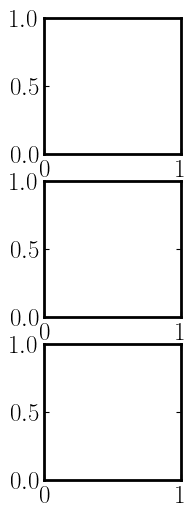

In [92]:
plt.close()
#infname0='./2_astro/cat0/outputs/multinest_mead20_cat0'
infname0='./0_fid/cat0/outputs/polychord_fid_cat0'
names = ["omega_m", "s_8", "alpha1"]
sample = MCSamplesFromCosmosis(infname0, as_correction=True)

g = GDplots.get_subplot_plotter()
g.triangle_plot([sample], params=names, filled=True)

In [93]:
stats = sample.getMargeStats()
lims0 = stats.parWithName('sigma_8').limits
lims1 = stats.parWithName('omega_m').limits
lims2 = stats.parWithName('s_8').limits
lims3 = stats.parWithName('alpha1').limits
print('sigma_8' ,(lims0[0].upper,lims0[0].lower))
print('omega_m' ,(lims1[0].upper,lims1[0].lower))
print('s_8' ,(lims2[0].upper,lims2[0].lower))
print('eta_1' ,(lims3[0].upper,lims3[0].lower))

sigma_8 (0.8971395736281873, 0.7343336866591776)
omega_m (0.30635046256196274, 0.21598777790438897)
s_8 (0.797741732672901, 0.737976668942098)
eta_1 (-2.0562200076954342, -6.0)
